<a href="https://colab.research.google.com/github/Nahmadid/WeeklyReport/blob/main/inv_3Cpt_Pk_Talaporfin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax
import numpy as np
from scipy.integrate import odeint
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import optax
import sys
import jax.nn as jnn
import matplotlib.pyplot as plt

In [2]:
# Data
t_label1 = [[0], [0.09595],[0.17676],[0.25757],[0.33838],[0.50505],[0.67171],[0.84848],[1],[1.16666],[1.24747],[1.41414]]
t1 = np.array([x[0] for x in t_label1])
c1 = np.array([59, 39.44727, 36.19782, 24.78948, 21.61946, 17.37336, 10.1553, 8.0222, 6.63457, 5.52865, 5.16237, 4.43028])


t_label2 = [[0], [0.176767], [0.67676]]
t2 = np.array([x[0] for x in t_label2])
mmyo = np.array([4.85981, 8.14641, 9.68847])



# Data
data_c1  = np.column_stack ([t1 ,c1]).astype(np.float32)
data_mmyo =np.column_stack([t2, mmyo]).astype(np.float32)
t_i  = jnp.array([[0]])
IC = np.array([59 , 0, 0]).astype(np.float32)
IC


array([59.,  0.,  0.], dtype=float32)

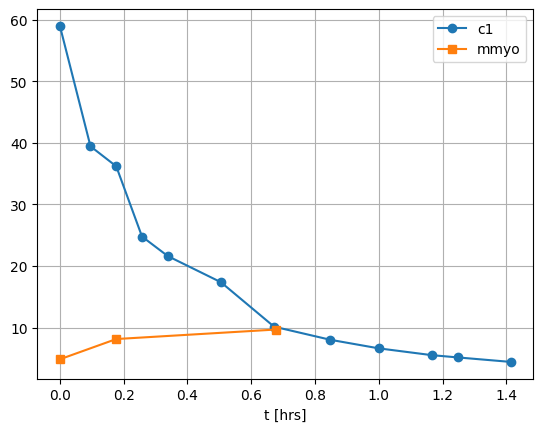

In [3]:
plt.figure()

plt.plot(t1, c1, marker='o', label='c1')
# Add a legend
plt.legend()
# Display the plot
plt.grid(True)
plt.plot(t2, mmyo, marker='s', label='mmyo')
# plt.plot(t_dense,y_dense[:,1],'r',label='')
# Add labels and title
plt.xlabel('t [hrs]')
# Add a legend
plt.legend()


In [7]:
t_dense = jnp.linspace(0, 5, 501)[:, None]
# tmin,tmax=0.
tmin, tmax = t_dense[0,0], t_dense[-1,0]

#t = (t-np.min(t))/(np.max(t)-np.min(t))
def init_params(layers):
    keys = jax.random.split(jax.random.PRNGKey(0), len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
        W = jax.random.normal(key, shape=(n_in, n_out)) / jnp.sqrt(n_in) # random initialization
        B = jax.random.normal(key, shape=(n_out,))
        params.append({'W': W, 'B': B, 'k10':0.5, 'k12':0.5,'k21':0.5,'k23':0.5,'k32':0.5})
        # params.append({'W': W, 'B': B, 'k10':0.5, 'k12':0.5})\
        # kij = jax.random.normal(key, shape=(5,))  # 5 parameters for kij
        # params.append({'W': W, 'B': B, 'kij': kij})
    return params


def fwd(params,t):
  # t = 0.01 * t
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
    # X = jnp.sin(X@layer['W']+layer['B'])
  X = X@last['W'] + last['B']
  return X # jnn.softplus(X)


@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)


def softplus(x):
    return jnp.log(1 + jnp.exp(x))

In [19]:
# t here should be t collocation points
def ODE_loss( params, t, y1, y2, y3,ft):
    V1 = 394
    V2 = 251
    V3 = 970
    k10 = 1.18
    k12 = 4.37
    # k21 = 7.85
    k23 = 6.41
    k32 = 0.75
    k21 = ft(t)

    # k10 = params[0]['k10']
    # k12 = params[0]['k12']
    # k21 = params[0]['k21']
    # k23 = params[0]['k23']
    # k32 = params[0]['k32']

    # k10 = softplus(params[-1]['kij'][0])
    # k12 = softplus(params[-1]['kij'][1])
    # k21 = softplus(params[-1]['kij'][2])
    # k23 = softplus(params[-1]['kij'][3])
    # k32 = softplus(params[-1]['kij'][4])

    y1_t = lambda t: jax.grad(lambda t: jnp.sum(y1(t)))(t)
    y2_t = lambda t: jax.grad(lambda t: jnp.sum(y2(t)))(t)
    y3_t = lambda t: jax.grad(lambda t: jnp.sum(y3(t)))(t)

    ode1 = y1_t(t) - (1/V1 * (-(k10 + k12) * V1 * y1(t) + k21 * y2(t) * V2))
    ode2 = y2_t(t) - (1/V2 * (k12 * V1 * y1(t) - (k21 + k23) * V2 * y2(t) + k32 * V3 * y3(t)))
    ode3 = y3_t(t) - (1/V3 * (k23 * V2 * y2(t) - k32 * V3 * y3(t)))

    return ode1, ode2, ode3


# t here should eb t data for Mmyo
def Cmyo_loss(y1, y2, y3, data_mmyo):
    t = data_mmyo[:,0:1]
    Mm = data_mmyo[:,1:2]
    # Rm = 0.189
    Cmyo = 0.08 * y1(t) + 0.189 * y2(t) + 0.731 * y3(t)
    # loss_Cmyo = Rm * Mm - Cmyo
    loss_Cmyo = Mm - Cmyo
    return loss_Cmyo


#collocation points
N_c = 500
t_c = jnp.linspace(tmin, tmax, N_c+1)[:, None]

# def loss_fun(params,params_extra, l1 ,l2 , t_i, t_d, t_c, data_IC, data_c1, data_mmyo):
def loss_fun(params, l1, l2, l3, t_i, t_c, data_IC, data_c1, data_mmyo):

    y1_func = lambda t: fwd(params, t)[:, [0]]
    y2_func = lambda t: fwd(params, t)[:, [1]]
    y3_func = lambda t: fwd(params, t)[:, [2]]
    ft      = lambda t: fwd(params, t)[:, [3]]
    # ft     = lambda t: fwd_extra(params_extra, t)[:, [0]]

    loss_Cmyo = Cmyo_loss(y1_func, y2_func, y3_func, data_mmyo)

    # loss_y1, loss_y2, loss_y3 = ODE_loss(t_c, params, y1_func, y2_func, y3_func, f_t)
    loss_y1, loss_y2, loss_y3 = ODE_loss(params, t_c, y1_func, y2_func, y3_func,ft)

    loss_y1 = l1 * loss_y1
    loss_y2 = l2 * loss_y2
    loss_y3 = l3 * loss_y3

    loss_ode1 = jnp.mean(loss_y1 ** 2)
    loss_ode2 = jnp.mean(loss_y2 ** 2)
    loss_ode3 = jnp.mean(loss_y3 ** 2)

    loss_Cmyo = jnp.mean(loss_Cmyo ** 2)

    # Compute the loss for the initial conditions
    t_i = t_i.flatten()[:,None]
    pred_IC = jnp.concatenate([y1_func(t_i), y2_func(t_i), y3_func(t_i)],axis=1)
    loss_IC = MSE(data_IC, pred_IC)


    # Compute the loss for Y_data
    t_d = data_c1[:,0:1]
    C1 = data_c1[:,1:2]
    t_d    = t_d.flatten()[:,None]
    pred_d = y1_func(t_d)
    loss_data = MSE(C1, pred_d)


    return loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3, loss_Cmyo



# def loss_fun_total(params, params_extra, l1,l2, t_i, t_d, t_c, data_IC, data, loss_weight):
def loss_fun_total(params, l1,l2, l3, t_i, t_c, data_IC, data_c1, data_mmyo, loss_weight):

    loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3, loss_Cmyo = loss_fun(params, l1,l2,l3, t_i, t_c, data_IC, data_c1, data_mmyo)

    loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
                + loss_weight[2]*loss_ode1 + loss_weight[3]*loss_ode2 + loss_weight[4]*loss_ode3 + loss_weight[5]* loss_Cmyo

    return loss_total




@jax.jit
# def update(opt_state, opt_state_extra, params, params_extra, params_l1, params_l2, opt_state_l1, opt_state_l2, t_i, t_data, t_c, IC, data, loss_weight):
#   grads=jax.grad(loss_fun_total, argnums=[0,1,2,3])(params,params_extra, params_l1, params_l2, t_i, t_data, t_c, IC, data, loss_weight)

def update(opt_state, params, params_l1, params_l2, params_l3, opt_state_l1, opt_state_l2,opt_state_l3, t_i, t_c, IC, data_c1, data_mmyo, loss_weight):
  grads=jax.grad(loss_fun_total, argnums=[0,1,2,3])(params, params_l1, params_l2, params_l3, t_i, t_c, IC,  data_c1, data_mmyo, loss_weight)

  #Update params
  updates, opt_state = optimizer.update(grads[0], opt_state)
  params = optax.apply_updates(params, updates)

  # updates_extra, opt_state_extra = optimizer_ex.update(grads[1], opt_state_extra)
  # params_extra = optax.apply_updates(params_extra, updates_extra)

  updates_l1, opt_state_l1 = optimizer.update(-grads[1], opt_state_l1)
  params_l1 = optax.apply_updates(params_l1, updates_l1)
  # params_l1 = 1
  updates_l2, opt_state_l2 = optimizer.update(-grads[2], opt_state_l2)
  params_l2 = optax.apply_updates(params_l2, updates_l2)
  # params_l2 = 1
  updates_l3, opt_state_l3 = optimizer.update(-grads[3], opt_state_l3)
  params_l3 = optax.apply_updates(params_l3, updates_l3)
  # params_l3 = 1
  # opt_state_l1, opt_state_l2, opt_state_l3 = 0 , 0 , 0
  return opt_state, params, params_l1, params_l2, params_l3, opt_state_l1, opt_state_l2, opt_state_l3





In [15]:
params = init_params([1] + [20]*4+[4])
# params_extra = init_params([1] + [20]*4+[1])  # Initialize parameters for the extra neural network

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)
# optimizer_ex = optax.adam(1e-5)
# opt_state_extra = optimizer_ex.init(params_extra)


keys = jax.random.split(jax.random.PRNGKey(0), 10)

lambda_1 = jax.random.uniform(keys[0], shape=(N_c + 1, 1))
lambda_2 = jax.random.uniform(keys[1], shape=(N_c + 1, 1))
lambda_3 = jax.random.uniform(keys[2], shape=(N_c + 1, 1))
# lambda_1 = 1
# lambda_2 = 1
# lambda_3 = 1
opt_state_l1 = optimizer.init(lambda_1)
opt_state_l2 = optimizer.init(lambda_2)
opt_state_l3 = optimizer.init(lambda_3)


#**Inverse constant**

In [12]:
# start_time = time.time()
epochs_phase1 = 0#10000
epochs_phase2 = 100000

loss_weight_phase1 = [1, 1, 0, 0, 0, 10]
loss_weight_phase2 = [1, 1, 1, 1, 1, 1]

loss_his, loss_indi_his, epoch_his = [], [], []

for ep in range(epochs_phase1 + epochs_phase2 + 1):
    if ep <= epochs_phase1:
        loss_weight = loss_weight_phase1
    else:
        loss_weight = loss_weight_phase2

    opt_state, params, params_l1,\
     params_l2, params_l3, opt_state_l1,\
      opt_state_l2, opt_state_l3 = update(opt_state, params,lambda_1, lambda_2, lambda_3, opt_state_l1,\
                                          opt_state_l2, opt_state_l3, t_i, t_c, IC, data_c1, data_mmyo, loss_weight)
    # print loss and epoch info
    if ep %(1000) ==0:
      loss_val = loss_fun_total(params, params_l1, params_l2, params_l3, t_i, t_c, IC, data_c1, data_mmyo, loss_weight)
      loss_val_individual = loss_fun(params, params_l1, params_l2, params_l3, t_i, t_c, IC, data_c1, data_mmyo)
      epoch_his.append(ep)
      loss_his.append(loss_val)
      loss_indi_his.append(loss_val_individual)
      # kb_updated = params[0]['kb']
      # kg_updated = params[0]['kg']
      k10 = params[0]['k10']
      k12 = params[0]['k12']
      k21 = params[0]['k21']
      k23 = params[0]['k23']
      k32 = params[0]['k32']
      # k10 = softplus(params[-1]['kij'][0])
      # k12 = softplus(params[-1]['kij'][1])
      # k21 = softplus(params[-1]['kij'][2])
      # k23 = softplus(params[-1]['kij'][3])
      # k32 = softplus(params[-1]['kij'][4])
      print(f'Epoch={ep}, \t loss={loss_val:.2e}, \t loss_IC={loss_val_individual[0]:.2e}, \t loss_d={loss_val_individual[1]:.2e}, \t loss_Cmyo={loss_val_individual[5]:.2e}, \t loss_e1={loss_val_individual[2]:.2e}, \t loss_e2={loss_val_individual[3]:.2e}, \t loss_e3={loss_val_individual[4]:.2e}')
      # print(f'k10 = {k10:.3e}, \t k12 = {k12:.3e}, \t k21 = {k21:.3e}, \t k23 = {k23:.3e}, \t k32 = {k32:.3e}')
      # print(f'k10 = {k10}, \t k12 = {k12}')
      # Append the values directly to the lists
      # kb_values_list.append(kb_updated)
      # kg_values_list.append(kg_updated)
      # np.savez(f'/content/drive/MyDrive/params_100_{ep}.npz', *params)
      # np.savez(f'/content/drive/MyDrive/params_extra_100_{ep}.npz', *params_extra)

# end_time = time.time()

# running_time = end_time - start_time
# print(f"Total running time: {running_time:.2f} seconds")

Epoch=0, 	 loss=2.56e+03, 	 loss_IC=1.18e+03, 	 loss_d=6.92e+02, 	 loss_Cmyo=6.80e+01, 	 loss_e1=5.61e-02, 	 loss_e2=1.15e-01, 	 loss_e3=3.99e-03
k10 = 5.000e-01, 	 k12 = 5.000e-01, 	 k21 = 5.000e-01, 	 k23 = 5.000e-01, 	 k32 = 5.000e-01
Epoch=1000, 	 loss=7.88e+02, 	 loss_IC=5.05e+02, 	 loss_d=2.74e+02, 	 loss_Cmyo=8.62e+00, 	 loss_e1=4.49e-06, 	 loss_e2=3.98e-05, 	 loss_e3=2.59e-05
k10 = 9.078e-04, 	 k12 = 3.657e-02, 	 k21 = 8.995e-01, 	 k23 = 8.957e-01, 	 k32 = 6.534e-02
Epoch=2000, 	 loss=6.74e+02, 	 loss_IC=3.24e+02, 	 loss_d=3.43e+02, 	 loss_Cmyo=7.86e+00, 	 loss_e1=6.70e-09, 	 loss_e2=2.76e-07, 	 loss_e3=1.01e-05
k10 = -5.136e-04, 	 k12 = 2.316e-02, 	 k21 = 9.026e-01, 	 k23 = 8.978e-01, 	 k32 = 5.849e-02
Epoch=3000, 	 loss=6.71e+02, 	 loss_IC=2.93e+02, 	 loss_d=3.70e+02, 	 loss_Cmyo=7.72e+00, 	 loss_e1=6.25e-10, 	 loss_e2=3.72e-10, 	 loss_e3=1.60e-08
k10 = -2.008e-05, 	 k12 = 2.105e-02, 	 k21 = 9.030e-01, 	 k23 = 8.974e-01, 	 k32 = 5.997e-02
Epoch=4000, 	 loss=6.71e+02, 	 loss_I

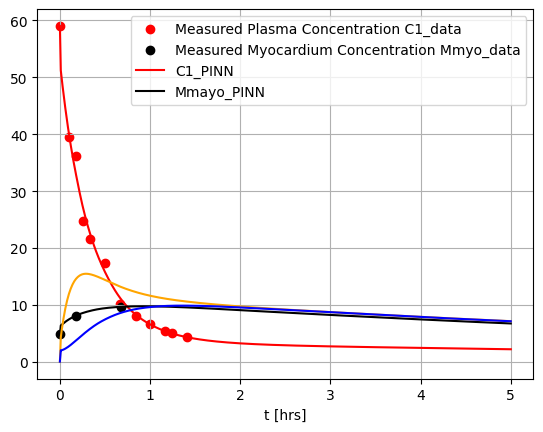

In [13]:

# pred = fwd(params,t_dense)
pred = fwd(params,t_dense)

import matplotlib.pyplot as plt

# Assuming t1, c1, t2, and mmyo are your data arrays

plt.figure()
Cmyo = (0.08 * pred[:,0] + 0.189 * pred[:,1] + 0.731 * pred[:,2])
# Plotting c1
plt.scatter(t1, c1, marker='o',color='red', label='Measured Plasma Concentration C1_data')
plt.scatter(t2, mmyo, marker='o', color='black', label='Measured Myocardium Concentration Mmyo_data')

plt.plot(t_dense, pred[:,0],'r',label='C1_PINN')
# Plotting mmyo
# plt.plot(t2, 0.189*mmyo, marker='s', label='mmyo')
plt.plot(t_dense , Cmyo , 'k',label='Mmayo_PINN')


plt.plot(t_dense,pred[:,1],'orange')
plt.plot(t_dense,pred[:,2],'b')
# Add labels and title
plt.xlabel('t [hrs]')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


#**Inerse ft = k23**

In [16]:
# start_time = time.time()
epochs_phase1 = 0#10000
epochs_phase2 = 100000

loss_weight_phase1 = [1, 1, 0, 0, 0, 10]
loss_weight_phase2 = [1, 1, 1, 1, 1, 1]

loss_his, loss_indi_his, epoch_his = [], [], []

for ep in range(epochs_phase1 + epochs_phase2 + 1):
    if ep <= epochs_phase1:
        loss_weight = loss_weight_phase1
    else:
        loss_weight = loss_weight_phase2

    opt_state, params, params_l1,\
     params_l2, params_l3, opt_state_l1,\
      opt_state_l2, opt_state_l3 = update(opt_state, params,lambda_1, lambda_2, lambda_3, opt_state_l1,\
                                          opt_state_l2, opt_state_l3, t_i, t_c, IC, data_c1, data_mmyo, loss_weight)
    # print loss and epoch info
    if ep %(1000) ==0:
      loss_val = loss_fun_total(params, params_l1, params_l2, params_l3, t_i, t_c, IC, data_c1, data_mmyo, loss_weight)
      loss_val_individual = loss_fun(params, params_l1, params_l2, params_l3, t_i, t_c, IC, data_c1, data_mmyo)
      epoch_his.append(ep)
      loss_his.append(loss_val)
      loss_indi_his.append(loss_val_individual)
      # kb_updated = params[0]['kb']
      # kg_updated = params[0]['kg']
      k10 = params[0]['k10']
      k12 = params[0]['k12']
      k21 = params[0]['k21']
      k23 = params[0]['k23']
      k32 = params[0]['k32']
      # k10 = softplus(params[-1]['kij'][0])
      # k12 = softplus(params[-1]['kij'][1])
      # k21 = softplus(params[-1]['kij'][2])
      # k23 = softplus(params[-1]['kij'][3])
      # k32 = softplus(params[-1]['kij'][4])
      print(f'Epoch={ep}, \t loss={loss_val:.2e}, \t loss_IC={loss_val_individual[0]:.2e}, \t loss_d={loss_val_individual[1]:.2e}, \t loss_Cmyo={loss_val_individual[5]:.2e}, \t loss_e1={loss_val_individual[2]:.2e}, \t loss_e2={loss_val_individual[3]:.2e}, \t loss_e3={loss_val_individual[4]:.2e}')
      # print(f'k10 = {k10:.3e}, \t k12 = {k12:.3e}, \t k21 = {k21:.3e}, \t k23 = {k23:.3e}, \t k32 = {k32:.3e}')
      # print(f'k10 = {k10}, \t k12 = {k12}')
      # Append the values directly to the lists
      # kb_values_list.append(kb_updated)
      # kg_values_list.append(kg_updated)
      # np.savez(f'/content/drive/MyDrive/params_100_{ep}.npz', *params)
      # np.savez(f'/content/drive/MyDrive/params_extra_100_{ep}.npz', *params_extra)

# end_time = time.time()

# running_time = end_time - start_time
# print(f"Total running time: {running_time:.2f} seconds")

Epoch=0, 	 loss=2.56e+03, 	 loss_IC=1.15e+03, 	 loss_d=6.62e+02, 	 loss_Cmyo=7.42e+01, 	 loss_e1=1.61e+01, 	 loss_e2=2.73e+01, 	 loss_e3=5.24e-02
Epoch=1000, 	 loss=1.01e+03, 	 loss_IC=6.92e+02, 	 loss_d=2.83e+02, 	 loss_Cmyo=4.95e+00, 	 loss_e1=2.02e+01, 	 loss_e2=4.63e-01, 	 loss_e3=7.01e+00
Epoch=2000, 	 loss=4.56e+02, 	 loss_IC=3.41e+02, 	 loss_d=9.37e+01, 	 loss_Cmyo=4.78e+00, 	 loss_e1=1.37e+01, 	 loss_e2=5.44e-01, 	 loss_e3=2.05e+00
Epoch=3000, 	 loss=9.03e+01, 	 loss_IC=5.72e+01, 	 loss_d=2.65e+01, 	 loss_Cmyo=4.62e-02, 	 loss_e1=5.38e+00, 	 loss_e2=4.36e-01, 	 loss_e3=7.69e-01
Epoch=4000, 	 loss=1.92e+01, 	 loss_IC=6.61e+00, 	 loss_d=8.85e+00, 	 loss_Cmyo=1.20e-01, 	 loss_e1=2.52e+00, 	 loss_e2=2.61e-01, 	 loss_e3=8.89e-01
Epoch=5000, 	 loss=7.57e+00, 	 loss_IC=8.20e-01, 	 loss_d=4.83e+00, 	 loss_Cmyo=1.22e-01, 	 loss_e1=1.13e+00, 	 loss_e2=1.49e-01, 	 loss_e3=5.16e-01
Epoch=6000, 	 loss=4.10e+00, 	 loss_IC=1.60e-01, 	 loss_d=3.13e+00, 	 loss_Cmyo=8.43e-02, 	 loss_e1=5.49e-01,

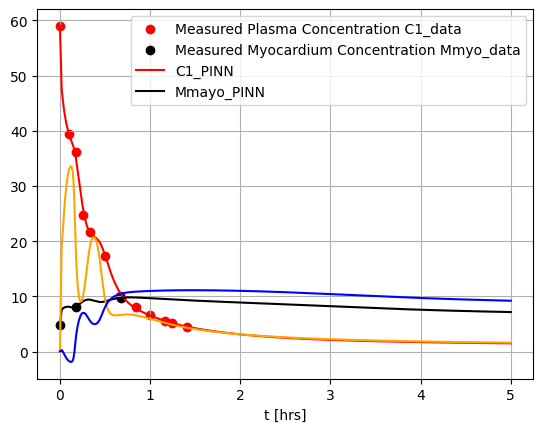

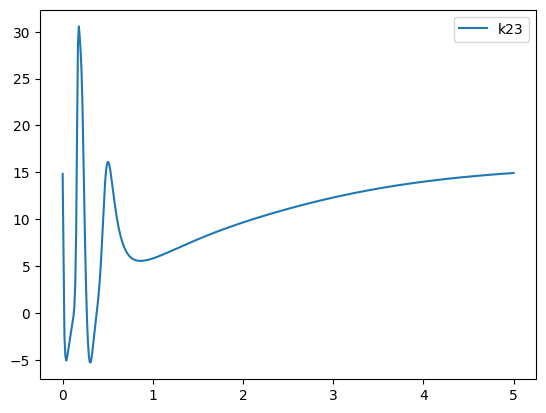

In [18]:

# pred = fwd(params,t_dense)
pred = fwd(params,t_dense)

import matplotlib.pyplot as plt

# Assuming t1, c1, t2, and mmyo are your data arrays

plt.figure()
Cmyo = (0.08 * pred[:,0] + 0.189 * pred[:,1] + 0.731 * pred[:,2])
# Plotting c1
plt.scatter(t1, c1, marker='o',color='red', label='Measured Plasma Concentration C1_data')
plt.scatter(t2, mmyo, marker='o', color='black', label='Measured Myocardium Concentration Mmyo_data')

plt.plot(t_dense, pred[:,0],'r',label='C1_PINN')
# Plotting mmyo
# plt.plot(t2, 0.189*mmyo, marker='s', label='mmyo')
plt.plot(t_dense , Cmyo , 'k',label='Mmayo_PINN')


plt.plot(t_dense,pred[:,1],'orange')
plt.plot(t_dense,pred[:,2],'b')
# Add labels and title
plt.xlabel('t [hrs]')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()
plt.figure()
plt.plot(t_dense,pred[:,3],label='k23')
plt.legend()


#**Inerse ft = k21**

In [ ]:
# start_time = time.time()
epochs_phase1 = 0#10000
epochs_phase2 = 100000

loss_weight_phase1 = [1, 1, 0, 0, 0, 10]
loss_weight_phase2 = [1, 1, 1, 1, 1, 1]

loss_his, loss_indi_his, epoch_his = [], [], []

for ep in range(epochs_phase1 + epochs_phase2 + 1):
    if ep <= epochs_phase1:
        loss_weight = loss_weight_phase1
    else:
        loss_weight = loss_weight_phase2

    opt_state, params, params_l1,\
     params_l2, params_l3, opt_state_l1,\
      opt_state_l2, opt_state_l3 = update(opt_state, params,lambda_1, lambda_2, lambda_3, opt_state_l1,\
                                          opt_state_l2, opt_state_l3, t_i, t_c, IC, data_c1, data_mmyo, loss_weight)
    # print loss and epoch info
    if ep %(1000) ==0:
      loss_val = loss_fun_total(params, params_l1, params_l2, params_l3, t_i, t_c, IC, data_c1, data_mmyo, loss_weight)
      loss_val_individual = loss_fun(params, params_l1, params_l2, params_l3, t_i, t_c, IC, data_c1, data_mmyo)
      epoch_his.append(ep)
      loss_his.append(loss_val)
      loss_indi_his.append(loss_val_individual)
      # kb_updated = params[0]['kb']
      # kg_updated = params[0]['kg']
      k10 = params[0]['k10']
      k12 = params[0]['k12']
      k21 = params[0]['k21']
      k23 = params[0]['k23']
      k32 = params[0]['k32']
      # k10 = softplus(params[-1]['kij'][0])
      # k12 = softplus(params[-1]['kij'][1])
      # k21 = softplus(params[-1]['kij'][2])
      # k23 = softplus(params[-1]['kij'][3])
      # k32 = softplus(params[-1]['kij'][4])
      print(f'Epoch={ep}, \t loss={loss_val:.2e}, \t loss_IC={loss_val_individual[0]:.2e}, \t loss_d={loss_val_individual[1]:.2e}, \t loss_Cmyo={loss_val_individual[5]:.2e}, \t loss_e1={loss_val_individual[2]:.2e}, \t loss_e2={loss_val_individual[3]:.2e}, \t loss_e3={loss_val_individual[4]:.2e}')
      # print(f'k10 = {k10:.3e}, \t k12 = {k12:.3e}, \t k21 = {k21:.3e}, \t k23 = {k23:.3e}, \t k32 = {k32:.3e}')
      # print(f'k10 = {k10}, \t k12 = {k12}')
      # Append the values directly to the lists
      # kb_values_list.append(kb_updated)
      # kg_values_list.append(kg_updated)
      # np.savez(f'/content/drive/MyDrive/params_100_{ep}.npz', *params)
      # np.savez(f'/content/drive/MyDrive/params_extra_100_{ep}.npz', *params_extra)

# end_time = time.time()

# running_time = end_time - start_time
# print(f"Total running time: {running_time:.2f} seconds")

Epoch=0, 	 loss=2.56e+03, 	 loss_IC=1.15e+03, 	 loss_d=6.62e+02, 	 loss_Cmyo=7.42e+01, 	 loss_e1=1.61e+01, 	 loss_e2=2.73e+01, 	 loss_e3=5.24e-02
Epoch=1000, 	 loss=1.01e+03, 	 loss_IC=6.92e+02, 	 loss_d=2.83e+02, 	 loss_Cmyo=4.95e+00, 	 loss_e1=2.02e+01, 	 loss_e2=4.63e-01, 	 loss_e3=7.01e+00
Epoch=2000, 	 loss=4.56e+02, 	 loss_IC=3.41e+02, 	 loss_d=9.37e+01, 	 loss_Cmyo=4.78e+00, 	 loss_e1=1.37e+01, 	 loss_e2=5.44e-01, 	 loss_e3=2.05e+00
Epoch=3000, 	 loss=9.03e+01, 	 loss_IC=5.72e+01, 	 loss_d=2.65e+01, 	 loss_Cmyo=4.62e-02, 	 loss_e1=5.38e+00, 	 loss_e2=4.36e-01, 	 loss_e3=7.69e-01
Epoch=4000, 	 loss=1.92e+01, 	 loss_IC=6.61e+00, 	 loss_d=8.85e+00, 	 loss_Cmyo=1.20e-01, 	 loss_e1=2.52e+00, 	 loss_e2=2.61e-01, 	 loss_e3=8.89e-01
Epoch=5000, 	 loss=7.57e+00, 	 loss_IC=8.20e-01, 	 loss_d=4.83e+00, 	 loss_Cmyo=1.22e-01, 	 loss_e1=1.13e+00, 	 loss_e2=1.49e-01, 	 loss_e3=5.16e-01
Epoch=6000, 	 loss=4.10e+00, 	 loss_IC=1.60e-01, 	 loss_d=3.13e+00, 	 loss_Cmyo=8.43e-02, 	 loss_e1=5.49e-01,

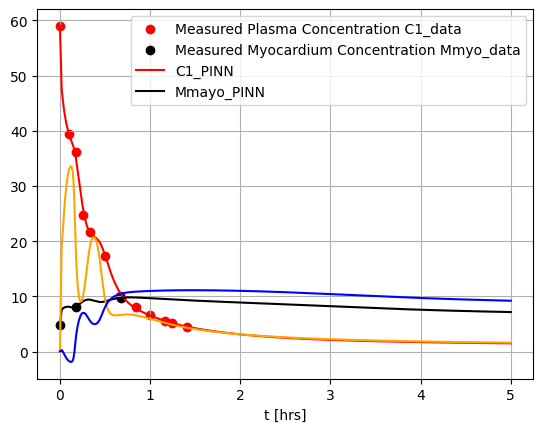

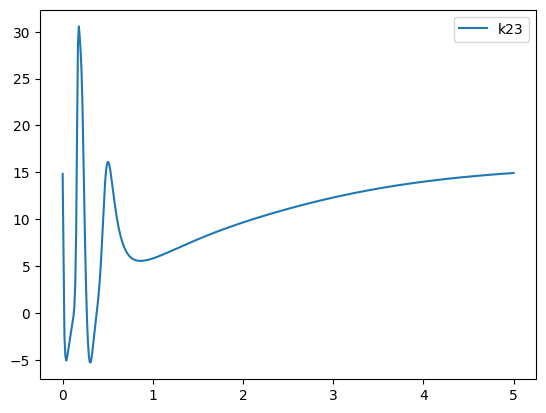

In [ ]:

# pred = fwd(params,t_dense)
pred = fwd(params,t_dense)

import matplotlib.pyplot as plt

# Assuming t1, c1, t2, and mmyo are your data arrays

plt.figure()
Cmyo = (0.08 * pred[:,0] + 0.189 * pred[:,1] + 0.731 * pred[:,2])
# Plotting c1
plt.scatter(t1, c1, marker='o',color='red', label='Measured Plasma Concentration C1_data')
plt.scatter(t2, mmyo, marker='o', color='black', label='Measured Myocardium Concentration Mmyo_data')

plt.plot(t_dense, pred[:,0],'r',label='C1_PINN')
# Plotting mmyo
# plt.plot(t2, 0.189*mmyo, marker='s', label='mmyo')
plt.plot(t_dense , Cmyo , 'k',label='Mmayo_PINN')


plt.plot(t_dense,pred[:,1],'orange')
plt.plot(t_dense,pred[:,2],'b')
# Add labels and title
plt.xlabel('t [hrs]')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()
plt.figure()
plt.plot(t_dense,pred[:,3],label='k23')
plt.legend()

#**frac**

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap
# from jax.experimental.optimizers import adam

import numpy as np
import time

def initialize_NN(layers):
    params = {'W': [], 'b': []}
    num_layers = len(layers)
    for l in range(0, num_layers-1):
        W = jnp.array(np.random.randn(layers[l], layers[l+1]), dtype=jnp.float32)
        b = jnp.zeros((1, layers[l+1]), dtype=jnp.float32)
        params['W'].append(W)
        params['b'].append(b)
    return params

def neural_net(params, X):
    num_layers = len(params['W'])
    H = 2.0 * (X - lb) / (ub - lb) - 1.0
    for l in range(num_layers - 1):
        W = params['W'][l]
        b = params['b'][l]
        H = jnp.tanh(jnp.dot(H, W) + b)
    W = params['W'][-1]
    b = params['b'][-1]
    Y = jnp.dot(H, W) + b
    return Y

def net_Uequ(x):
    alpha = 1.7
    N = 128
    dx1 = x / N
    dx2 = (1 - x) / N

    g_coeff = jnp.zeros(N + 1, dtype=jnp.float64)
    g_coeff = jax.ops.index_update(g_coeff, 0, 1.0)
    for i in range(N):
        g_coeff = jax.ops.index_update(g_coeff, i+1, ((i-alpha)/(i+1)) * g_coeff[i])

    u1 = 0
    for k in range(0, N+1):
        u1 += g_coeff[k] * neural_net(params, x - (k-1)*dx1) * (x - (k-1)*dx1) * (1 - (x - (k-1)*dx1))

    u2 = 0
    for k2 in range(0, N+1):
        u2 += g_coeff[k2] * neural_net(params, x + (k2-1)*dx2) * (x + (k2-1)*dx2) * (1 - (x + (k2-1)*dx2))

    f = (1 / (2 * jnp.cos(0.5 * jnp.pi * 1.7))) * ((jnp.math.gamma(4) / jnp.math.gamma(4 - 1.7)) * (x**(3 - 1.7) + (1 - x)**(3 - 1.7)) - \
                                           3 * (jnp.math.gamma(5) / jnp.math.gamma(5 - 1.7)) * (x**(4 - 1.7) + (1 - x)**(4 - 1.7)) + \
                                           3 * (jnp.math.gamma(6) / jnp.math.gamma(6 - 1.7)) * (x**(5 - 1.7) + (1 - x)**(5 - 1.7)) - \
                                           (jnp.math.gamma(7) / jnp.math.gamma(7 - 1.7)) * (x**(6 - 1.7) + (1 - x)**(6 - 1.7)))

    Uu = (1 / (2 * jnp.cos(0.5 * jnp.pi * alpha))) * ((1 / (dx1**alpha)) * u1 + (1 / (dx2**alpha)) * u2) - f

    return Uu

def net_Uout(x):
    U1 = neural_net(params, x) * x * (1 - x)
    return U1

def loss(params, x_data, x_gg_data):
    Uequ_pred = net_Uequ(x_data)
    Ugg_pred = net_Uout(x_gg_data)

    u_star2 = x_gg_data**3 * (1 - x_gg_data)**3

    loss_equ = jnp.sum(Uequ_pred**2)
    loss_gg = jnp.sum((Ugg_pred - u_star2)**2)

    return loss_equ + 15 * loss_gg

# Define the gradient of the loss function
grad_loss = grad(loss)

# JAX optimizer
def train(params, x_data, x_gg_data, num_epochs, learning_rate):
    opt_init, opt_update, get_params = optax.adam(learning_rate)
    opt_state = opt_init(params)

    def step(i, opt_state):
        params = get_params(opt_state)
        return opt_update(i, grad_loss(params, x_data, x_gg_data), opt_state)

    for epoch in range(num_epochs):
        opt_state = jit(step)(epoch, opt_state)

    return get_params(opt_state)

if __name__ == "__main__":
    layers = [1, 20, 20, 20, 20, 1]
    lb = jnp.array([0.0], dtype=jnp.float32)
    ub = jnp.array([1.0], dtype=jnp.float32)

    x_f = jnp.array([[0.5], [0.75]], dtype=jnp.float32)
    x_gg = jnp.array([[0.6501465], [0.9001465]], dtype=jnp.float32)

    params = initialize_NN(layers)

    num_epochs = 100000
    learning_rate = 0.001

    params = train(params, x_f, x_gg, num_epochs, learning_rate)

    U1_pred = net_Uout(x_gg)

    u = x_gg**2
    uu = u * x_gg
    w = (1 - x_gg)**2
    ww = w * (1 - x_gg)
    u_star = uu * ww

    error_u = jnp.linalg.norm(u_star - U1_pred, 2) / jnp.linalg.norm(u_star, 2)

    print('U:', U1_pred)
    print('error:', error_u)
